In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Activation
from keras.layers.normalization import BatchNormalization
import cv2
from PIL import Image

Using TensorFlow backend.


In [4]:
class_labels = os.listdir("../input/plantdisease/PlantVillage")
n_classes = len(class_labels)
print("Total no of class : ",n_classes)

Total no of class :  15


In [9]:
# Creating dataset
data_path = "../input/plantdisease/PlantVillage/"
data = []
label = []
try:
    for class_name in class_labels:
        for image_name in os.listdir(data_path+class_name):
            try:
                image = cv2.imread(data_path+class_name+"/"+image_name)
                image_array = Image.fromarray(image, 'RGB')
                resize_img = image_array.resize((150 , 150))
                data.append(np.array(resize_img))
                label.append(class_labels.index(class_name))
            except AttributeError:
                print('')
        print(class_labels.index(class_name),len(data), len(label))
except:
    print(" ")

0 1909 1909
1 2909 2909
2 4313 4313
3 5791 5791
4 6791 6791
5 8918 8918
6 9915 9915

7 13123 13123
8 14075 14075
9 15751 15751
10 17342 17342
11 17494 17494
12 18494 18494
13 18867 18867
14 20638 20638


In [10]:
print("Total data size :", len(data))

Total data size : 20638


In [11]:
# converting list into numpy array
data = np.array(data)
label = np.array(label)

In [12]:
# since the data is in specific order we need to shuffle it
n = np.arange(data.shape[0])
np.random.shuffle(n)
data = data[n]
label = label[n]

In [13]:
data = data.astype(np.float32)
label = label.astype(np.float32)
data = data / 255.0

In [14]:
label.shape, data.shape

((20638,), (20638, 150, 150, 3))

*As we can see here label shape is (20638,) but for the multiclass classification where number of classes is 15, we need our label to have shape (20638, 15) and for that we need to one hot encode our label numpy array, But first we need to convert label 1D array into 2D array using np.newaxis.*

In [15]:
label = label[:, np.newaxis]
label.shape

(20638, 1)

In [16]:
#One hot encoding
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
label = ohe.fit_transform(label)
label.shape

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(20638, 15)

In [17]:
# Spliting data into train - test
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(data, label, test_size=0.2, random_state=1)

In [18]:
train_x.shape, test_x.shape, train_y.shape

((16510, 150, 150, 3), (4128, 150, 150, 3), (16510, 15))

Now let's create our model. This model is inspired from the Tairu Oluwafemi Emmanuel notebook.
Link : https://www.kaggle.com/emmarex/plant-disease-detection-using-keras

In [19]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding="same",input_shape=(150, 150, 3), activation='relu'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(15))
model.add(Activation("softmax"))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 32)       

In [21]:
opt = keras.optimizers.Adam(lr=1e-3, decay=1e-3 / 25)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [23]:
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=15, batch_size = 32)

Train on 16510 samples, validate on 4128 samples
Epoch 1/15
16510/16510 [==============================] - 21s 1ms/step - loss: 0.0145 - accuracy: 0.9948 - val_loss: 0.0324 - val_accuracy: 0.9899
Epoch 2/15
16510/16510 [==============================] - 21s 1ms/step - loss: 0.0128 - accuracy: 0.9953 - val_loss: 0.0681 - val_accuracy: 0.9791
Epoch 3/15
16510/16510 [==============================] - 21s 1ms/step - loss: 0.0135 - accuracy: 0.9951 - val_loss: 0.1899 - val_accuracy: 0.9579
Epoch 4/15
16510/16510 [==============================] - 20s 1ms/step - loss: 0.0114 - accuracy: 0.9960 - val_loss: 0.0870 - val_accuracy: 0.9779
Epoch 5/15
16510/16510 [==============================] - 21s 1ms/step - loss: 0.0164 - accuracy: 0.9941 - val_loss: 0.0467 - val_accuracy: 0.9849
Epoch 6/15
16510/16510 [==============================] - 20s 1ms/step - loss: 0.0126 - accuracy: 0.9955 - val_loss: 0.0403 - val_accuracy: 0.9883
Epoch 7/15
16510/16510 [==============================] - 20s 1ms/ste

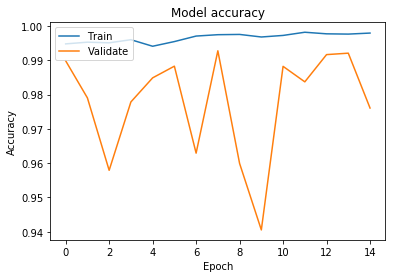

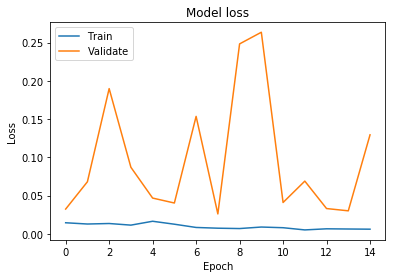

In [26]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [28]:
score = model.evaluate(test_x,test_y,verbose=0)
print('Test Loss :',score[0])
print('Test Accuracy :',score[1])

Test Loss : 0.1294260448667892
Test Accuracy : 0.9760979413986206
